# K-Means

In [11]:
# Import libraries
import glob
import numpy as np
import PIL.Image as Image
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.spatial import distance

from sklearn.manifold import TSNE
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import distance_metric, type_metric
from pyclustering.cluster.center_initializer import random_center_initializer

In [5]:
# Calculates 1d Power Spectrum
def power_spectrum_1d(image):

    # Get pixel count
    pixel_count = image.shape[0]

    # Convert into fourier transform
    fourier_image = np.fft.fftn(image)
    fourier_amplitudes = np.abs(fourier_image)

    #Calculate 1D power spectrum
    k_frequencies = np.fft.fftfreq(pixel_count) * pixel_count
    k_frequencies2D = np.meshgrid(k_frequencies, k_frequencies)
    k_norm = np.sqrt(k_frequencies2D[0] ** 2 + k_frequencies2D[1] ** 2)
    k_bins = np.arange(0.5, pixel_count // 2 + 1, 1.)
    k_vals = 0.5 * (k_bins[1:] + k_bins[:-1])
    a_bins, _, _ = stats.binned_statistic(k_norm.flatten(),
                                        (fourier_amplitudes ** 2).flatten(),
                                        statistic = "mean", bins = k_bins)
    a_bins *= np.pi * (k_bins[1:] ** 2 - k_bins[:-1] ** 2)
    
    return a_bins

# Calculates Wasserstein distance of two images
def wasserstein(x, y): 
    return stats.wasserstein_distance(np.arange(len(x)), np.arange(len(y)), x, y)

In [36]:
# Collect all images in AIA171_Miniset_BW and represent them as 1D power specturm numpy arrays
images = []
x = []
image_paths = glob.glob('./../../AIA171_Miniset_BW/**/*.jpg', recursive = True)
for image_path in image_paths:
    image = Image.open(image_path).convert('L')
    image = np.array(image)
    image = image.astype(float) / 255
    pow_spect = power_spectrum_1d(image)
    if pow_spect.any():
        images.append(image)
        x.append(pow_spect)
images = np.array(images)
x = np.array(x)   

In [37]:
print(x.shape)

(112320, 64)


In [22]:
print(x.shape)

(115248, 64)


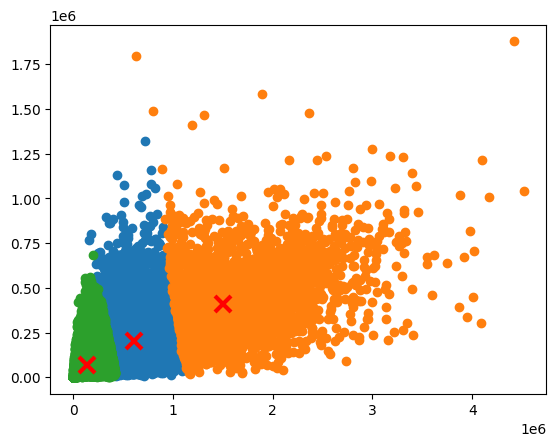

In [40]:
# Perform K-Means with pyclustering
initial_centers = random_center_initializer(x, 3).initialize()
model = kmeans(x, initial_centers = initial_centers, metric = distance_metric(type_metric.EUCLIDEAN))
model.process()
clusters_idx = model.get_clusters()
centers = np.array(model.get_centers())

clusters = []
clusters_img = []
for cluster_idx in clusters_idx:
    cluster = np.array([x[i] for i in cluster_idx])
    clusters.append(cluster)

for cluster in clusters:
    plt.scatter(cluster[:,0], cluster[:,1])
plt.plot(centers[:,0], centers[:,1], 'rx', ms = 12, mew = 3)
plt.show()

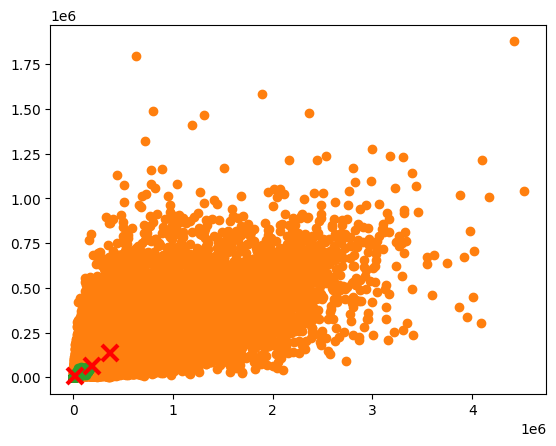

In [38]:
# Perform K-Means with pyclustering
initial_centers = random_center_initializer(x, 3).initialize()
model = kmeans(x, initial_centers = initial_centers, metric = distance_metric(type_metric.USER_DEFINED, func = wasserstein))
model.process()
clusters_idx = model.get_clusters()
centers = np.array(model.get_centers())

clusters = []
clusters_img = []
for cluster_idx in clusters_idx:
    cluster = np.array([x[i] for i in cluster_idx])
    clusters.append(cluster)

for cluster in clusters:
    plt.scatter(cluster[:,0], cluster[:,1])
plt.plot(centers[:,0], centers[:,1], 'rx', ms = 12, mew = 3)
plt.show()

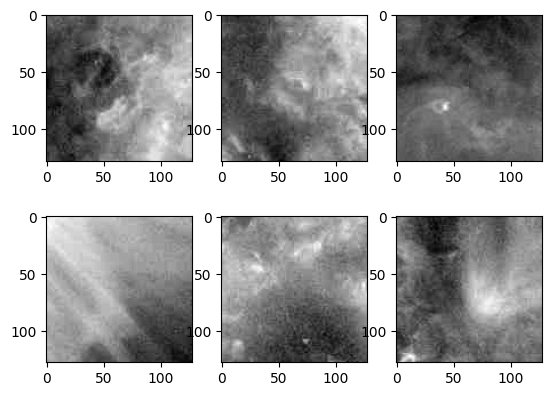

In [8]:
def nearest_neighbors(data, sample, k, images):
    distances = []
    neighbors = []

    for j, i in enumerate(data):
        distances.append((distance.euclidean(sample, i), j))
    
    distances = sorted(distances)

    for i in range(k + 1):
        neighbors.append(images[distances[i][1]])
    
    return neighbors

index = np.random.randint(len(x))

neighbors = nearest_neighbors(x, x[index], 5, images)

fig, ax = plt.subplots(2, 3)
ax[0][0].imshow(neighbors[0], cmap = 'gray')
ax[0][1].imshow(neighbors[1], cmap = 'gray')
ax[0][2].imshow(neighbors[2], cmap = 'gray')
ax[1][0].imshow(neighbors[3], cmap = 'gray')
ax[1][1].imshow(neighbors[4], cmap = 'gray')
ax[1][2].imshow(neighbors[5], cmap = 'gray')